In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:

train_image_path=glob.glob('dc_2000/train/*/*.jpg')
train_image_path[-5:]

['dc_2000/train\\dog\\dog.995.jpg',
 'dc_2000/train\\dog\\dog.996.jpg',
 'dc_2000/train\\dog\\dog.997.jpg',
 'dc_2000/train\\dog\\dog.998.jpg',
 'dc_2000/train\\dog\\dog.999.jpg']

In [3]:
import random
test_image_path=glob.glob('dc_2000/test/*/*.jpg')
test_image_path[:3]

['dc_2000/test\\cat\\cat.1000.jpg',
 'dc_2000/test\\cat\\cat.1001.jpg',
 'dc_2000/test\\cat\\cat.1002.jpg']

In [4]:
train_labels=[s.split('\\')[1] for s in train_image_path]
train_labels[-5:]

['dog', 'dog', 'dog', 'dog', 'dog']

In [5]:
test_labels=[s.split('\\')[1] for s in test_image_path]
test_labels[:3]
#提取每张图片的标签
label_to_index={'dog':0,'cat':1}
train_labels_nums=[label_to_index.get(l) for l in train_labels]
test_labels_nums=[label_to_index.get(l) for l in test_labels]#将标签转化成数字方便我们处理

In [6]:
def load_img(path,label):
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img,[360,360])#将图像扭曲并不影响我们对于图像的判断
    img=tf.image.random_crop(img,[256,256,3])#随机裁剪函数
    img=tf.image.random_flip_left_right(img)#随机左右翻转
    img=tf.image.random_flip_up_down(img)#随机上下翻转
    img=tf.image.random_brightness(img,0.5)#随机亮度
    img=tf.image.random_contrast(img,0,1)
    img=tf.cast(img,tf.float32)
    img=img/255
    label=tf.reshape(label,[1])#将数据转化为每个一维的数据
    #处理图像数据,使用这个函数如果图像数据类型不是float它会自动做归一化
    return img,label

In [7]:
train_data=tf.data.Dataset.from_tensor_slices((train_image_path,train_labels_nums))
train_data=train_data.map(load_img)
train_data

<MapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

In [8]:
test_data=tf.data.Dataset.from_tensor_slices((test_image_path,test_labels_nums))
test_data=test_data.map(load_img)
test_data

<MapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

In [9]:
BATCH_SIZE=32
train_count=len(train_image_path)
train_data=train_data.shuffle(1000).batch(BATCH_SIZE)


In [10]:
imgs,labels=next(iter(train_data))
imgs.shape

TensorShape([32, 256, 256, 3])

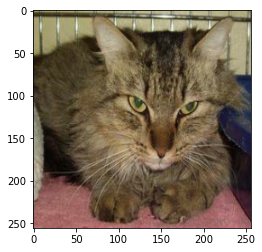

In [11]:
plt.imshow(imgs[0])


In [18]:
model=keras.Sequential()
model.add(layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(512,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(1024,(3,3),activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))#可激活也可不激活只要对输出了解可以修改
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 512)      

In [16]:
#高级的API加自定义训练
losses=keras.losses.BinaryCrossentropy()#二分类的损失函数
losses([0.,1.,0.,1.],[1.,1.,1.,1.])#计算交叉熵损失
#大写的更像是返回一个可调用对象

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [19]:
optimizer=keras.optimizers.Adam()
train_loss=keras.metrics.Mean('train_loss')
train_accuracy=keras.metrics.Accuracy()


In [ ]:
def train_step(model,images,lables):
    with tf.GradientTape as t:
        pred=model(images)
        loss_step=keras.losses.BinaryCrossentropy()(labels,pred)
    gradies=t.gradient(loss_step,model.trainable_variables)
    optimizer.apply_gradients(gradies,model.trainable_variables)
    train_loss(looss_step)
    pred=tf.cast(pred>0.5,tf.int32)
    train_accuracy(labels,pred)

In [21]:
all_loss=[]
all_accuracy=[]


In [ ]:
for epoch in range(20):
    for x,y in train_data:
        train_step(model,x,y)
        print('-')
    print('>')
    print()
    all_loss.append(train_loss.result())
    all_accuracy.append(train_accuracy.result())
    print('Epoch {}: loss: {:.3f}, accuracy: {:.3f}'.format(epoch+1,train_loss.result(),train_accuracy.result()))

    train_loss.reset_states()
    train_accuracy.reset_states()

In [26]:
import numpy as np
ll=np.array([[1]])
ll=ll.reshape(1)
print(ll[0])

1
